In [142]:
# Import dependencies
import os, sys
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# import keras 


In [148]:
def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)
    # ax.xaxis.set_ticklabels(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],fontsize=10)
    # ax.yaxis.set_ticklabels(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],fontsize=10)

In [5]:
# labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
# X = []
# y = []
# samples = 15000

# Downsize images to 50 x 50 pixels

In [3]:
labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
X = []
y = []
samples = 15000
pixels = 50

for label in labels:
    folder = './Rice_Image_Dataset/' + label + '/'
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(samples):
        img = Image.open(folder + "/" + files[i])
        img_gray = img.convert('L')
        img_gray.thumbnail((pixels, pixels)) # resize to 50 x 50
        img_array = np.asarray(img_gray)
        X.append(img_array)
        y.append(label)

X = np.asarray(X)
Xr = X.reshape(5*samples, pixels*pixels)
y = np.array(y)

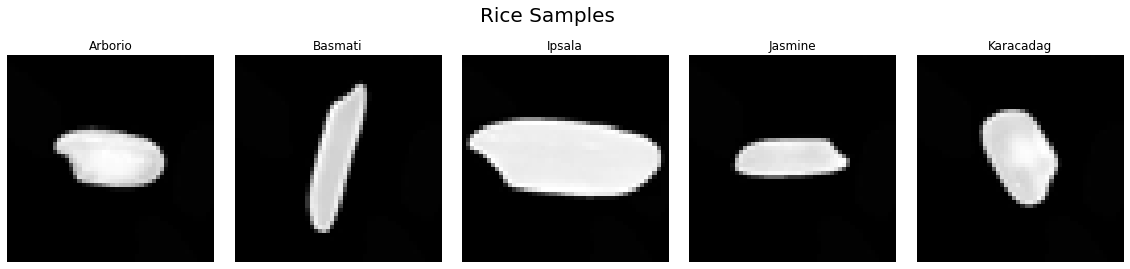

In [8]:
# Show rice
def show_rice(Xr, y, cols=5, title=None):
    fig, axs = plt.subplots(1, cols, figsize=(20,5))
    plt.axis('off')
    for i in range(len(labels)):
        rice = labels[i]
        idx = np.argwhere(y == rice)[0]
        im = Xr[idx].reshape(pixels, pixels)
        axs[i].set_title(f'{rice}')
        axs[i].imshow(im, cmap='gray')
        axs[i].axis('off')
    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=20)
        fig.subplots_adjust(top=0.99)
    
show_rice(Xr, y, title='Rice Samples')

In [ ]:
# labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
# X = []
# y = []
# samples = 15000

# for label in labels:
#     folder = './Rice_Image_Dataset_50/' + label + '/'
#     files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
#     for i in range(samples):
#         img = Image.open(folder + "/" + files[i])
#         img_gray = img.convert('L')
#         img_array = np.asarray(img_gray)
#         X.append(img_array)
#         y.append(label)

# X = np.asarray(X)
# Xr = X.reshape(5*samples, 62500)
# y = np.array(y)

# Split dataset

In [113]:
# Split dataset
X_train, X_remaining, y_train, y_remaining = train_test_split(Xr, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state = 42)

# PCA

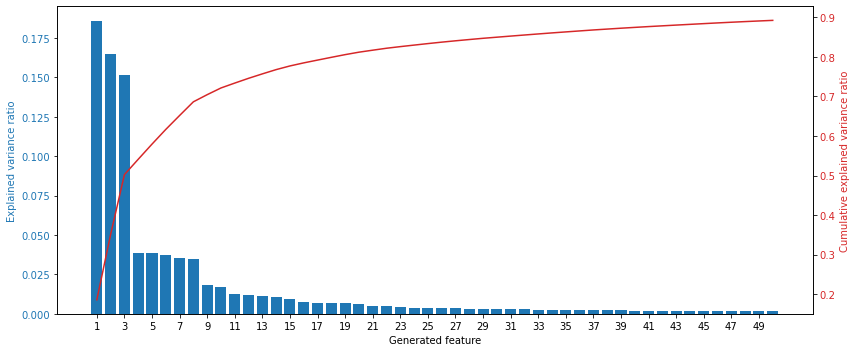

In [5]:
# Fit PCA with N = 100
N = 50
pca = PCA(n_components=N) 
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


In [108]:
# N = 50
# pca.set_params(n_components=N)
# X_train_reduced = pca.fit_transform(X_train)

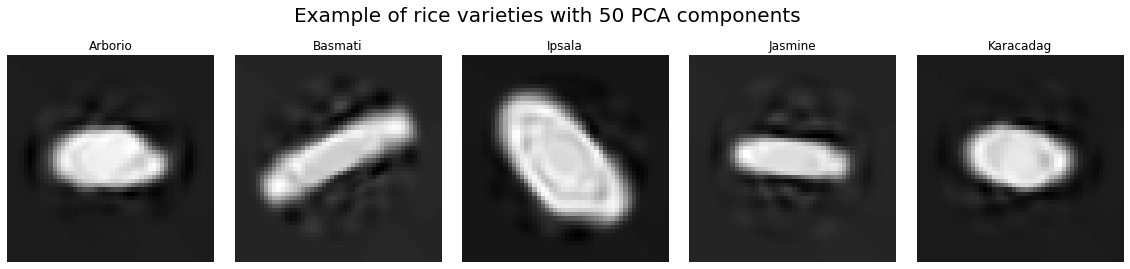

In [109]:
X_val_reduced = pca.transform(X_val)

show_rice(pca.inverse_transform(X_train_reduced), y_train, title=f'Example of rice varieties with {N} PCA components')
plt.show()

# Logistic Regression

### Hyperparamter tuning: Adjusting regularization strength for logistic regression

In [111]:
training_accuracy_list = []
validation_accuracy_list = []
C_list = []

# C_values = np.linspace(0.01, 10, 10)
C_values = np.logspace(-3, 4, 8)

for i in C_values:
    log_reg = LogisticRegression(solver='saga', max_iter = 500, C=i) 
    log_reg.fit(X_train_reduced, y_train)
    y_train_pred = log_reg.predict(X_train_reduced)
    y_val_pred = log_reg.predict(X_val_reduced)
    training_accuracy = accuracy_score(y_train, y_train_pred) # compute the accuracy score
    validation_accuracy = accuracy_score(y_val, y_val_pred)
    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    C_list.append(i)

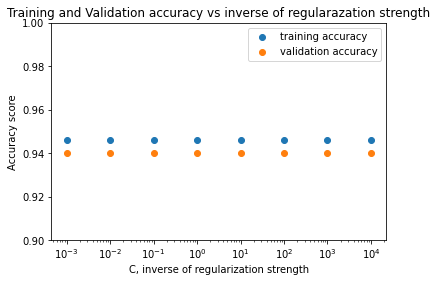

In [112]:
# Plot C vs accuracy
plt.scatter(C_list, training_accuracy_list, label="training accuracy")
plt.scatter(C_list, validation_accuracy_list, label="validation accuracy")
plt.xlabel("C, inverse of regularization strength")
plt.ylabel("Accuracy score")
plt.title("Training and Validation accuracy vs inverse of regularazation strength")
ax = plt.gca()

ax.set_xscale('log')
# ax.set_xlim([xmin, xmax])
plt.legend()
ax.set_ylim([0.9, 1])
plt.show()

### Training on combined training and validation set, testing on test set

In [135]:
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

N = 50
pca = PCA(n_components=N) 
X_combined_reduced = pca.fit_transform(X_combined)

# print(len(X_train[:,0]))
# print(len(X_combined[:,0]))

log_reg = LogisticRegression(solver='saga', max_iter = 500) 
log_reg.fit(X_combined_reduced, y_combined)

LogisticRegression(max_iter=500, solver='saga')

In [137]:
# Testing
X_test_reduced = pca.transform(X_test)
y_test_pred = log_reg.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training prediction accuracy: {100*test_accuracy:.2f}%")

Training prediction accuracy: 95.00%


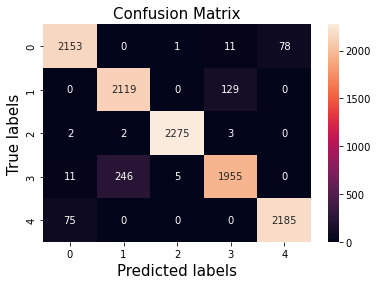

In [149]:
generate_confusion_matrix(y_test, y_test_pred)

## NOT INCLUDED IN REPORT Multi-layer Perceptron

0.9696888888888889


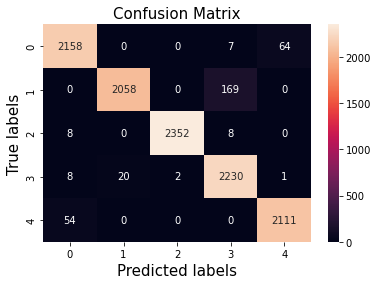

In [77]:
# Multi-layer Perceptron
# pixels = 50, samples = 15000

MLPclf = MLPClassifier(random_state=1, activation='relu').fit(X_train_reduced, y_train)

X_val_reduced = pca.transform(X_val)

# MLPclf.predict_proba(X_val)
y_pred = MLPclf.predict(X_val_reduced)
# print(MLPclf.score(X_val,y_val))
generate_confusion_matrix(y_val, y_pred)
print(accuracy_score(y_pred, y_val))

### NOT INCLUDED IN REPORT: Hyperparameter tuning: Adjusting l1_ratio for elasticnet penalty, logistic regression

In [96]:
training_accuracy_list = []
validation_accuracy_list = []

l1_ratio_list = np.linspace(0, 1, 50)


for i in l1_ratio_list:
    print(i)
    log_reg = LogisticRegression(solver='saga', max_iter = 500, C=1.0, penalty='elasticnet', l1_ratio = i) # create the object, SET solver='sag'
    log_reg.fit(X_train_reduced, y_train)
    y_train_pred = log_reg.predict(X_train_reduced)
    y_val_pred = log_reg.predict(X_val_reduced)
    training_accuracy = accuracy_score(y_train, y_train_pred) # compute the accuracy score
    validation_accuracy = accuracy_score(y_val, y_val_pred)
    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.1020408163265306
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.18367346938775508
0.2040816326530612
0.22448979591836732
0.24489795918367346
0.26530612244897955
0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464
0.4693877551020408
0.4897959183673469
0.5102040816326531
0.5306122448979591
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591836
0.6326530612244897
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857142
0.7346938775510203
0.7551020408163265
0.7755102040816326
0.7959183673469387
0.8163265306122448
0.836734693877551
0.8571428571428571
0.8775510204081632
0.8979591836734693
0.9183673469387754
0.9387755102040816
0.9591836734693877
0.9795918367346939
1.0


In [99]:
print(training_accuracy_list)
print(validation_accuracy_list)

[0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460571428571428, 0.9460380952380952, 0.9460571428571428, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460571428571428, 0.9460380952380952, 0.9460380952380952, 0.9460571428571428, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952, 0.9460380952380952]

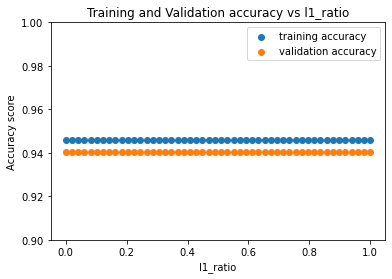

In [103]:
# Plot l1_ratio vs accuracy
# l1_ratio_list = l1_ratio_list.tolist()

plt.scatter(l1_ratio_list, training_accuracy_list, label="training accuracy")
plt.scatter(l1_ratio_list, validation_accuracy_list, label="validation accuracy")
plt.xlabel("l1_ratio")
plt.ylabel("Accuracy score")
plt.title("Training and Validation accuracy vs l1_ratio")
ax = plt.gca()
# ax.set_xlim([xmin, xmax])
plt.legend()
ax.set_ylim([0.9, 1])
plt.show()

In [52]:
y_train_pred = log_reg.predict(X_train_reduced) # compute the prediction on the validating set
training_accuracy = accuracy_score(y_train, y_train_pred) # compute the accuracy score
print(f"Training prediction accuracy: {100*training_accuracy:.2f}%")

X_val_reduced = pca.transform(X_val)
y_val_pred = log_reg.predict(X_val_reduced)
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation prediction accuracy: {100*validation_accuracy:.2f}%")

Training prediction accuracy: 94.61%
Validation prediction accuracy: 93.99%
